In [1]:
import json
import os
import string
import re
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from preprocessing.MILP_Algorithm import select_LP_optimal_subsequence
import numpy as np
from sklearn import tree
from tqdm import tqdm
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, operator
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy import stats


# Read the data

In [2]:
eval_pred = open("data/milp_NewsQA_eval_pred.txt", "r")
test_pred = open("data/milp_NewsQA_test_pred.txt", "r")
y2_eval = open("data/milp_NewsQA_y2_eval.txt", "r")
y3_eval = open("data/milp_NewsQA_y3_eval.txt", "r")
y2_test = open("data/milp_NewsQA_y2_test.txt", "r")
y3_test = open("data/milp_NewsQA_y3_test.txt", "r")
token_type_eval = open("data/milp_NewsQA_token_type_eval.txt", "r")
token_type_test = open("data/milp_NewsQA_token_type_test.txt", "r")
input_ids_test = open("data/milp_NewsQA_input_ids_test.txt", "r")

eval_pred  = json.loads(eval_pred.read())
test_pred  = json.loads(test_pred.read())
y2_eval  = json.loads(y2_eval.read())
y3_eval  = json.loads(y3_eval.read())
y2_test  = json.loads(y2_test.read())
y3_test  = json.loads(y3_test.read())
token_type_eval  = json.loads(token_type_eval.read())
token_type_test  = json.loads(token_type_test.read())
input_ids_test  = json.loads(input_ids_test.read())

eval_pred = [[0 if math.isnan(y) else y for y in x] for x in eval_pred]
test_pred = [[0 if math.isnan(y) else y for y in x] for x in test_pred]


In [3]:
# set max length value
max_len = 300
# Create the tokenizer
save_path = os.path.expanduser("~") + "/.bert_base_uncased/"
if not os.path.exists(save_path):
    slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    os.makedirs(save_path)
    slow_tokenizer.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(save_path + "vocab.txt", lowercase=True)


In [10]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text



In [9]:
def get_performance(s_pred, e_pred, s_ans, e_ans):       
    prediction = input_ids_test[idx][s_pred:e_pred+1]
    ans = input_ids_test[idx][s_ans:e_ans+1]
    normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
    normalized_true_ans = normalize_text(tokenizer.decode(ans))
    correct = 0
    if normalized_pred_ans == normalized_true_ans:
        correct = 1
    prediction = set(normalized_pred_ans.split(' '))
    true = set(normalized_true_ans.split(' '))
    inter = set(prediction & true)
    p = len(inter) / len(prediction)
    r = len(inter) / len(true)  
    f1 = 0
    if (p+r) !=0:
        f1 = 2*p*r / (p+r)        
    return correct, f1, p, r
            
        

# MILP
## Using a Decision tree to find the answerability threshold

In [4]:
eval_pred_start_end = []
with tqdm(total=len(eval_pred)) as pbar:
    for idx, probabilities in enumerate(eval_pred):
        start_context_idx = token_type_eval[idx].index(1)
        end_context_idx = len(token_type_eval[idx]) - 1 - token_type_eval[idx][::-1].index(1)
        s_pred,e_pred,_ = select_LP_optimal_subsequence(probabilities[start_context_idx:end_context_idx+1]) # do not consider element at index 0        
        eval_pred_start_end.append([s_pred+start_context_idx, e_pred+start_context_idx])  
        pbar.update(1)


  0%|          | 0/4534 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2021-07-22
Using license file /home/reda/gurobi.lic


100%|██████████| 4534/4534 [58:22<00:00,  1.29it/s]  


Accuracy:  0.8061314512571681


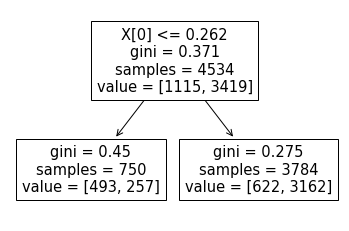

In [5]:
X = []
y = []
for idx, s_pred_e_pred in enumerate(eval_pred_start_end):
    s_pred = s_pred_e_pred[0]
    e_pred = s_pred_e_pred[1]
    prediction = list(range(s_pred, e_pred+1))    
    expected_p = np.sum(eval_pred[idx][s_pred:e_pred+1]) / len(prediction)
    X.append([expected_p])
#     X.append([eval_pred[idx][0]])
    if np.sum(y2_eval[idx]) == 0:
        y.append(0)
    else:
        y.append(1)

clf_MILP = tree.DecisionTreeClassifier(max_depth=1)
clf_MILP.fit(X, y)
tree.plot_tree(clf_MILP)
print('Accuracy: ', accuracy_score(clf_MILP.predict(X), y))


In [6]:
test_pred_start_end = []
with tqdm(total=len(test_pred)) as pbar:
    for idx, probabilities in enumerate(test_pred):
        start_context_idx = token_type_test[idx].index(1)
        end_context_idx = len(token_type_test[idx]) - 1 - token_type_test[idx][::-1].index(1)
        s_pred, e_pred,_ = select_LP_optimal_subsequence(probabilities[start_context_idx:end_context_idx+1]) # do not consider element at index 0        
        test_pred_start_end.append([s_pred+start_context_idx, e_pred+start_context_idx])  
        pbar.update(1)


100%|██████████| 4493/4493 [49:45<00:00,  1.50it/s]  


## Compute performance

In [8]:
count_MILP = []
p_MILP = []
r_MILP = []
f1_MILP = []

TN_MILP = 0
FN_MILP = 0
TP_MILP = 0
FP_MILP = 0
TAG_MILP = []
with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        s_pred = s_pred_e_pred[0]
        e_pred = s_pred_e_pred[1]        
        prediction = input_ids_test[idx][s_pred:e_pred+1]
        expected_p = np.sum(test_pred[idx][s_pred:e_pred+1]) / len(prediction) 
#         answerability = clf_MILP.predict([[test_pred[idx][0]]])[0]
        answerability = clf_MILP.predict([[expected_p]])[0]
        if  answerability == 0 and np.sum(y2_test[idx]) == 0: # Correct predicion of unanswerability
            TN_MILP += 1
            TAG_MILP.append('TN')
            p_MILP.append(1)
            r_MILP.append(1)
            f1_MILP.append(1)
            count_MILP.append(1)
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}±{(1.96 * np.std(count_MILP))/np.sqrt(len(count_MILP)):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")
            pbar.update(1)
            continue
        elif (answerability == 1 and np.sum(y2_test[idx]) == 0) or (answerability == 0 and np.sum(y2_test[idx]) > 0):
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_MILP += 1
                TAG_MILP.append('FP')
            else:
                FN_MILP += 1
                TAG_MILP.append('FN')
            p_MILP.append(0)
            r_MILP.append(0)
            f1_MILP.append(0)
            count_MILP.append(0)            
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}±{(1.96 * np.std(count_MILP))/np.sqrt(len(count_MILP)):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability      
            TP_MILP += 1
            TAG_MILP.append('TP')            
            ans = input_ids_test[idx][y3_test[idx][0]:y3_test[idx][-1]+1]
            normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
            normalized_true_ans = normalize_text(tokenizer.decode(ans))
            if normalized_pred_ans == normalized_true_ans:
                count_MILP.append(1)
            else:
                count_MILP.append(0)
            prediction = set(normalized_pred_ans.split(' '))
            true = set(normalized_true_ans.split(' '))
            inter = set(prediction & true)
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(true)  
            f1_ = 0
            if (p_+r_) !=0:
                f1_ = 2*p_*r_ / (p_+r_)
            p_MILP.append(p_)
            r_MILP.append(r_)
            f1_MILP.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}±{(1.96 * np.std(count_MILP))/np.sqrt(len(count_MILP)):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")    
            pbar.update(1)

print(f"[TP={TP_MILP/len(TAG_MILP):.3f}±{(1.96 * np.std(count_MILP))/np.sqrt(len(count_MILP)):.3f}|TN={TN_MILP/len(TAG_MILP):.3f}|FP={FP_MILP/len(TAG_MILP):.3f}|FN={FN_MILP/len(TAG_MILP):.3f}]")




[EM=0.425±0.014|F1=0.577±0.013|P=0.569±0.013|R=0.636±0.014]: 100%|██████████| 4493/4493 [00:14<00:00, 313.83it/s]


[TP=0.696±0.014|TN=0.098|FP=0.151|FN=0.055]


# Baseline 1
## Using a Decision tree to find the answerability threshold

In [9]:
eval_pred_start_baseline1 = open("data/Baseline1_NewsQA_eval_pred_start.txt", "r")
eval_pred_end_baseline1 = open("data/Baseline1_NewsQA_eval_pred_end.txt", "r")
test_pred_start_baseline1 = open("data/Baseline1_NewsQA_test_pred_start.txt", "r")
test_pred_end_baseline1 = open("data/Baseline1_NewsQA_test_pred_end.txt", "r")
y2_eval_baseline1 = open("data/Baseline1_NewsQA_y2_eval.txt", "r")
y3_eval_baseline1 = open("data/Baseline1_NewsQA_y3_eval.txt", "r")
y2_test_baseline1 = open("data/Baseline1_NewsQA_y2_test.txt", "r")
y3_test_baseline1 = open("data/Baseline1_NewsQA_y3_test.txt", "r")
token_type_eval_baseline1 = open("data/Baseline1_NewsQA_token_type_eval.txt", "r")
token_type_test_baseline1 = open("data/Baseline1_NewsQA_token_type_test.txt", "r")
input_ids_test_baseline1 = open("data/Baseline1_NewsQA_input_ids_test.txt", "r")

eval_pred_start_baseline1  = json.loads(eval_pred_start_baseline1.read())
eval_pred_end_baseline1  = json.loads(eval_pred_end_baseline1.read())
test_pred_start_baseline1  = json.loads(test_pred_start_baseline1.read())
test_pred_end_baseline1  = json.loads(test_pred_end_baseline1.read())
y2_eval_baseline1  = json.loads(y2_eval_baseline1.read())
y3_eval_baseline1  = json.loads(y3_eval_baseline1.read())
y2_test_baseline1  = json.loads(y2_test_baseline1.read())
y3_test_baseline1  = json.loads(y3_test_baseline1.read())


token_type_eval_baseline1  = json.loads(token_type_eval_baseline1.read())
token_type_test_baseline1  = json.loads(token_type_test_baseline1.read())
input_ids_test_baseline1  = json.loads(input_ids_test_baseline1.read())

eval_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_start_baseline1]
eval_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_end_baseline1]
test_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_start_baseline1]
test_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_end_baseline1]


Accuracy:  0.8385531539479488


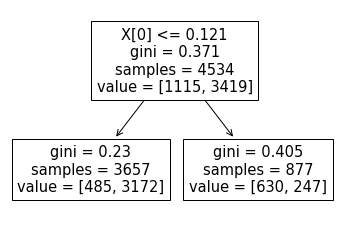

In [10]:
X_baseline1 = []
y_baseline1 = []
for idx, (start, end) in enumerate(zip(eval_pred_start_baseline1, eval_pred_end_baseline1)):
    start_context_idx = token_type_eval_baseline1[idx].index(1)
    end_context_idx = len(token_type_eval_baseline1[idx]) - 1 - token_type_eval_baseline1[idx][::-1].index(1)
    s_pred = np.max(start[start_context_idx:end_context_idx+1]) + np.max(end[start_context_idx:end_context_idx+1])
    s_null = start[0] + end[0]
    X_baseline1.append([s_null-s_pred])
    if np.sum(y2_eval_baseline1[idx]) == 0:
        y_baseline1.append(0)
    else:
        y_baseline1.append(1)  

clf_Baseline1 = tree.DecisionTreeClassifier(max_depth=1)
clf_Baseline1.fit(X_baseline1, y_baseline1)
tree.plot_tree(clf_Baseline1)         
print('Accuracy: ', accuracy_score(clf_Baseline1.predict(X_baseline1), y_baseline1))


In [11]:
count_Baseline1 = []
p_Baseline1 = []
r_Baseline1 = []
f1_Baseline1 = []

TN_Baseline1 = 0
FN_Baseline1 = 0
TP_Baseline1 = 0
FP_Baseline1 = 0
TAG_Baseline1 = []

with tqdm(total=len(test_pred_start_baseline1)) as pbar:
    for idx, (start, end) in enumerate(zip(test_pred_start_baseline1, test_pred_end_baseline1)): 
        start_context_idx = token_type_test_baseline1[idx].index(1)
        end_context_idx = len(token_type_test_baseline1[idx]) - 1 - token_type_test_baseline1[idx][::-1].index(1)
        s_pred = np.max(start[start_context_idx:end_context_idx+1]) + np.max(end[start_context_idx:end_context_idx+1])
        s_null = start[0] + end[0]
        answerability = clf_Baseline1.predict([[s_null-s_pred]])[0]        
        if  answerability == 0 and np.sum(y2_test_baseline1[idx]) == 0: # Correct predicion of unanswerability
            TN_Baseline1 += 1
            TAG_Baseline1.append('TN')
            p_Baseline1.append(1)
            r_Baseline1.append(1)
            f1_Baseline1.append(1)
            count_Baseline1.append(1)
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}±{(1.96 * np.std(count_Baseline1))/np.sqrt(len(count_Baseline1)):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
            continue
        elif (answerability == 1 and np.sum(y2_test_baseline1[idx]) == 0) or (answerability == 0 and np.sum(y2_test_baseline1[idx]) > 0):
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_Baseline1 += 1
                TAG_Baseline1.append('FP')
            else:
                FN_Baseline1 += 1
                TAG_Baseline1.append('FN')
            p_Baseline1.append(0)
            r_Baseline1.append(0)
            f1_Baseline1.append(0)
            count_Baseline1.append(0)            
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}±{(1.96 * np.std(count_Baseline1))/np.sqrt(len(count_Baseline1)):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability   
            TP_Baseline1 += 1
            TAG_Baseline1.append('TP')
            s_pred = np.argmax(start[start_context_idx:end_context_idx+1]) + start_context_idx
            e_pred = np.argmax(end[start_context_idx:end_context_idx+1]) + start_context_idx         
            prediction = input_ids_test_baseline1[idx][s_pred:e_pred+1]            
            ans = input_ids_test_baseline1[idx][y3_test[idx][0]:y3_test[idx][-1]+1]            
            normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
            normalized_true_ans = normalize_text(tokenizer.decode(ans))            
            prediction = set(normalized_pred_ans.split(' '))
            true = set(normalized_true_ans.split(' '))
            inter = list(prediction & true)
            if len(prediction) == 0:
                p_Baseline1.append(0)
                r_Baseline1.append(0)
                f1_Baseline1.append(0)
                count_Baseline1.append(0)
                pbar.update(1)
                continue
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(ans)
            f1_ = 0
            if (p_+r_) !=0:
                f1_ = 2*p_*r_ / (p_+r_)
            if f1_ == 1:
                count_Baseline1.append(1)
            else:
                count_Baseline1.append(0)
            p_Baseline1.append(p_)
            r_Baseline1.append(r_)
            f1_Baseline1.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}±{(1.96 * np.std(count_Baseline1))/np.sqrt(len(count_Baseline1)):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
    
print(f"[TP={TP_Baseline1/len(TAG_Baseline1):.3f}|TN={TN_Baseline1/len(TAG_Baseline1):.3f}|FP={FP_Baseline1/len(TAG_Baseline1):.3f}|FN={FN_Baseline1/len(TAG_Baseline1):.3f}]")


[EM=0.301±0.013|F1=0.540±0.012|P=0.613±0.013|R=0.540±0.012]: 100%|██████████| 4493/4493 [00:15<00:00, 299.42it/s]

[TP=0.688|TN=0.132|FP=0.118|FN=0.062]


# Baseline 2

In [12]:
def baseline2(A):
    B = np.where(np.array(A) > 0.5, 1, 0)
    if np.sum(B) == 0:
        return -1, -1
    else:
        r = max((list(y) for (x,y) in itertools.groupby((enumerate(B)),operator.itemgetter(1)) if x == 1), key=len)
        return r[0][0], r[-1][0]
    
    

In [13]:
count_Baseline2 = []
p_Baseline2 = []
r_Baseline2 = []
f1_Baseline2 = []

TN_Baseline2 = 0
FN_Baseline2 = 0
TP_Baseline2 = 0
FP_Baseline2 = 0
TAG_Baseline2 = []

with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        start_context_idx = token_type_test_baseline1[idx].index(1)
        end_context_idx = len(token_type_test_baseline1[idx]) - 1 - token_type_test_baseline1[idx][::-1].index(1)
        probabilities = test_pred[idx][start_context_idx:end_context_idx+1]   
        s_pred, e_pred = baseline2(probabilities)                
        answerability = 1
        if s_pred == -1 or e_pred == -1:
            answerability = 0       
        
        if  answerability == 0 and np.sum(y2_test[idx]) == 0: # Correct predicion of unanswerability
            TN_Baseline2 += 1
            TAG_Baseline2.append('TN')
            p_Baseline2.append(1)
            r_Baseline2.append(1)
            f1_Baseline2.append(1)
            count_Baseline2.append(1)
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}±{(1.96 * np.std(count_Baseline2))/np.sqrt(len(count_Baseline2)):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
            pbar.update(1)
            continue
        elif (answerability == 1 and np.sum(y2_test[idx]) == 0) or (answerability == 0 and np.sum(y2_test[idx]) > 0):
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_Baseline2 += 1
                TAG_Baseline2.append('FP')
            else:
                FN_Baseline2 += 1
                TAG_Baseline2.append('FN')
            p_Baseline2.append(0)
            r_Baseline2.append(0)
            f1_Baseline2.append(0)
            count_Baseline2.append(0)            
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}±{(1.96 * np.std(count_Baseline2))/np.sqrt(len(count_Baseline2)):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability
            TP_Baseline2 += 1
            TAG_Baseline2.append('TP')
            
            s_pred = s_pred + start_context_idx
            e_pred = e_pred + start_context_idx
            
            prediction = input_ids_test_baseline1[idx][s_pred:e_pred+1]            
            ans = input_ids_test_baseline1[idx][y3_test[idx][0]:y3_test[idx][-1]+1]            
            normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
            normalized_true_ans = normalize_text(tokenizer.decode(ans))            
            prediction = set(normalized_pred_ans.split(' '))
            true = set(normalized_true_ans.split(' '))
            inter = list(prediction & true)
            if len(prediction) == 0:
                p_Baseline2.append(0)
                r_Baseline2.append(0)
                f1_Baseline2.append(0)
                count_Baseline2.append(0)
                pbar.update(1)
                continue
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(ans)
            f1_ = 0
            if (p_+r_) !=0:
                f1_ = 2*p_*r_ / (p_+r_)
            if f1_ == 1:
                count_Baseline2.append(1)
            else:
                count_Baseline2.append(0)
            p_Baseline2.append(p_)
            r_Baseline2.append(r_)
            f1_Baseline2.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}±{(1.96 * np.std(count_Baseline2))/np.sqrt(len(count_Baseline2)):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
            pbar.update(1)

print(f"[TP={TP_Baseline2/len(TAG_Baseline2):.3f}|TN={TN_Baseline2/len(TAG_Baseline2):.3f}|FP={FP_Baseline2/len(TAG_Baseline2):.3f}|FN={FN_Baseline2/len(TAG_Baseline2):.3f}]")


[EM=0.279±0.013|F1=0.508±0.012|P=0.591±0.014|R=0.487±0.012]: 100%|██████████| 4493/4493 [00:13<00:00, 323.86it/s]

[TP=0.618|TN=0.139|FP=0.110|FN=0.133]


# Answer Pointer BM

In [7]:
eval_pred_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_eval_pred.txt", "r")
test_pred_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_test_pred.txt", "r")
y2_eval_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_y2_eval.txt", "r")
y3_eval_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_y3_eval.txt", "r")
y2_test_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_y2_test.txt", "r")
y3_test_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_y3_test.txt", "r")
token_type_eval_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_token_type_eval.txt", "r")
token_type_test_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_token_type_test.txt", "r")
input_ids_test_answer_pointer_BM = open("data/Answer_Pointer_BM_NewsQA_input_ids_test.txt", "r")

eval_pred_answer_pointer_BM  = json.loads(eval_pred_answer_pointer_BM.read())
test_pred_answer_pointer_BM  = json.loads(test_pred_answer_pointer_BM.read())
y2_eval_answer_pointer_BM  = json.loads(y2_eval_answer_pointer_BM.read())
y3_eval_answer_pointer_BM  = json.loads(y3_eval_answer_pointer_BM.read())
y2_test_answer_pointer_BM  = json.loads(y2_test_answer_pointer_BM.read())
y3_test_answer_pointer_BM  = json.loads(y3_test_answer_pointer_BM.read())


token_type_eval_answer_pointer_BM  = json.loads(token_type_eval_answer_pointer_BM.read())
token_type_test_answer_pointer_BM  = json.loads(token_type_test_answer_pointer_BM.read())
input_ids_test_answer_pointer_BM  = json.loads(input_ids_test_answer_pointer_BM.read())

eval_pred_answer_pointer_BM = [[[0 if math.isnan(z) else z for z in y] for y in x] for x in eval_pred_answer_pointer_BM]
test_pred_answer_pointer_BM = [[[0 if math.isnan(z) else z for z in y] for y in x] for x in test_pred_answer_pointer_BM]


In [157]:
count_Ans_Pt_BM = []
p_Ans_Pt_BM = []
r_Ans_Pt_BM = []
f1_Ans_Pt_BM = []

with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, (start, end) in enumerate(test_pred_answer_pointer_BM):
        start_context_idx = token_type_test_answer_pointer_BM[idx].index(1)
        end_context_idx = len(token_type_test_answer_pointer_BM[idx]) - 1 - token_type_test_answer_pointer_BM[idx][::-1].index(1)
        # Prediction
        s_pred = np.argmax(start[start_context_idx:end_context_idx+1]) + start_context_idx
        e_pred = np.argmax(end[start_context_idx:end_context_idx+1]) + start_context_idx
        # True answer
        s_ans = y3_test_answer_pointer_BM[idx][0]
        e_ans = y3_test_answer_pointer_BM[idx][-1]
        
        correct, f1, p, r = get_performance(s_pred, e_pred, s_ans, e_ans)
        
        count_Ans_Pt_BM.append(correct)
        p_Ans_Pt_BM.append(p)
        r_Ans_Pt_BM.append(r)
        f1_Ans_Pt_BM.append(f1)
        pbar.set_description(f"[EM={np.mean(count_Ans_Pt_BM):.3f}±{(1.96 * np.std(count_Ans_Pt_BM))/np.sqrt(len(count_Ans_Pt_BM)):.3f}|F1={np.mean(f1_Ans_Pt_BM):.3f}±{(1.96 * np.std(f1_Ans_Pt_BM))/np.sqrt(len(f1_Ans_Pt_BM)):.3f}|P={np.mean(p_Ans_Pt_BM):.3f}±{(1.96 * np.std(p_Ans_Pt_BM))/np.sqrt(len(p_Ans_Pt_BM)):.3f}|R={np.mean(r_Ans_Pt_BM):.3f}±{(1.96 * np.std(r_Ans_Pt_BM))/np.sqrt(len(r_Ans_Pt_BM)):.3f}]")
        pbar.update(1)


# Answer Pointer SM

In [ ]:
eval_pred_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_eval_pred.txt", "r")
test_pred_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_test_pred.txt", "r")
y2_eval_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_y2_eval.txt", "r")
y3_eval_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_y3_eval.txt", "r")
y2_test_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_y2_test.txt", "r")
y3_test_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_y3_test.txt", "r")
token_type_eval_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_token_type_eval.txt", "r")
token_type_test_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_token_type_test.txt", "r")
input_ids_test_answer_pointer_SM = open("data/Answer_Pointer_SM_NewsQA_input_ids_test.txt", "r")

eval_pred_answer_pointer_SM  = json.loads(eval_pred_answer_pointer_SM.read())
test_pred_answer_pointer_SM  = json.loads(test_pred_answer_pointer_SM.read())
y2_eval_answer_pointer_SM  = json.loads(y2_eval_answer_pointer_SM.read())
y3_eval_answer_pointer_SM  = json.loads(y3_eval_answer_pointer_SM.read())
y2_test_answer_pointer_SM  = json.loads(y2_test_answer_pointer_SM.read())
y3_test_answer_pointer_SM  = json.loads(y3_test_answer_pointer_SM.read())


token_type_eval_answer_pointer_SM  = json.loads(token_type_eval_answer_pointer_SM.read())
token_type_test_answer_pointer_SM  = json.loads(token_type_test_answer_pointer_SM.read())
input_ids_test_answer_pointer_SM  = json.loads(input_ids_test_answer_pointer_SM.read())

eval_pred_answer_pointer_SM = [[[0 if math.isnan(z) else z for z in y] for y in x] for x in eval_pred_answer_pointer_SM]
test_pred_answer_pointer_SM = [[[0 if math.isnan(z) else z for z in y] for y in x] for x in test_pred_answer_pointer_SM]


In [158]:
count_Ans_Pt_SM = []
p_Ans_Pt_SM = []
r_Ans_Pt_SM = []
f1_Ans_Pt_SM = []

with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, (start, end) in enumerate(test_pred_answer_pointer_SM):
        start_context_idx = token_type_test_answer_pointer_SM[idx].index(1)
        end_context_idx = len(token_type_test_answer_pointer_SM[idx]) - 1 - token_type_test_answer_pointer_SM[idx][::-1].index(1)
        # Prediction
        s_pred = np.argmax(start[start_context_idx:end_context_idx+1]) + start_context_idx
        e_pred = np.argmax(end[start_context_idx:end_context_idx+1]) + start_context_idx
        # True answer
        s_ans = y3_test[idx][0]
        e_ans = y3_test[idx][-1]
        
        correct, f1, p, r = get_performance(s_pred, e_pred, s_ans, e_ans)
        
        count_Ans_Pt_SM.append(correct)
        p_Ans_Pt_SM.append(p)
        r_Ans_Pt_SM.append(r)
        f1_Ans_Pt_SM.append(f1)
        pbar.set_description(f"[EM={np.mean(count_Ans_Pt_SM):.3f}±{(1.96 * np.std(count_Ans_Pt_SM))/np.sqrt(len(count_Ans_Pt_SM)):.3f}|F1={np.mean(f1_Ans_Pt_SM):.3f}±{(1.96 * np.std(f1_Ans_Pt_SM))/np.sqrt(len(f1_Ans_Pt_SM)):.3f}|P={np.mean(p_Ans_Pt_SM):.3f}±{(1.96 * np.std(p_Ans_Pt_SM))/np.sqrt(len(p_Ans_Pt_SM)):.3f}|R={np.mean(r_Ans_Pt_SM):.3f}±{(1.96 * np.std(r_Ans_Pt_SM))/np.sqrt(len(r_Ans_Pt_SM)):.3f}]")
        pbar.update(1)


# Plots

In [171]:
data = pd.DataFrame(columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy'])
data_list = list(zip(['MILP']*len(count_MILP), count_MILP, f1_MILP, p_MILP, r_MILP, TAG_MILP))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy']),ignore_index=True)

data_list = list(zip(['BERT-Devlin']*len(count_Baseline1), count_Baseline1, f1_Baseline1, p_Baseline1, r_Baseline1, TAG_Baseline1))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy']),ignore_index=True)

data_list = list(zip(['Max len']*len(count_Baseline2), count_Baseline2, f1_Baseline2, p_Baseline2, r_Baseline2, TAG_Baseline2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy']),ignore_index=True)

data_list = list(zip(['Ans Ptr BM']*len(count_Ans_Pt_BM), count_Ans_Pt_BM, f1_Ans_Pt_BM, p_Ans_Pt_BM, r_Ans_Pt_BM, TAG_Ans_Pt_BM))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy']),ignore_index=True)

data_list = list(zip(['Ans Ptr SM']*len(count_Ans_Pt_SM), count_Ans_Pt_SM, f1_Ans_Pt_SM, p_Ans_Pt_SM, r_Ans_Pt_SM, TAG_Ans_Pt_SM))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall', 'clf_accuracy']),ignore_index=True)


data["clf_accuracy"].replace({"TP": 1, "TN": 1,"FP": 0, "FN": 0}, inplace=True)



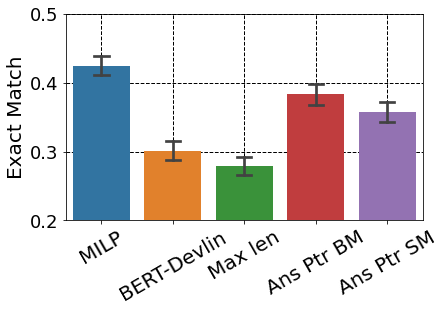

In [172]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(6.4, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Exact Match")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.2, 0.5)
plt.xticks(rotation=30)

plt.savefig('plots/em_NewsQA.eps', bbox_inches = 'tight')
plt.show()


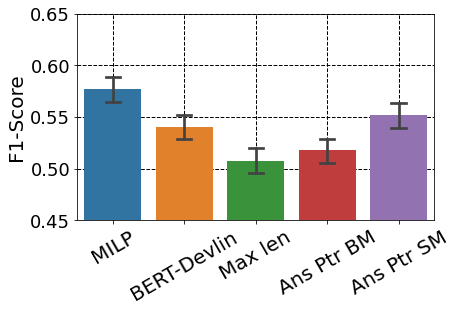

In [173]:
# statistic, pvalue = stats.ttest_ind(f1_2, f1_baseline2)
plt.figure(figsize=(6.4, 3.8))

ax = sns.barplot(x="algo", y="f1", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("F1-Score")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.45, 0.65)
plt.xticks(rotation=30)

plt.savefig('plots/f1_score_NewsQA.eps', bbox_inches = 'tight')
plt.show()


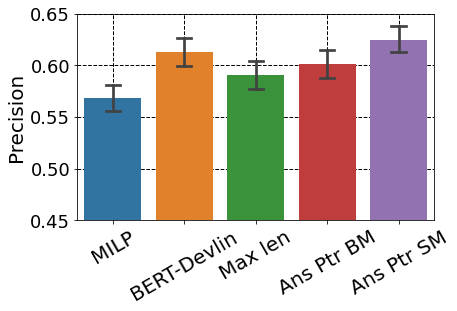

In [174]:
# statistic, pvalue = stats.ttest_ind(p2, p_baseline2)
plt.figure(figsize=(6.4, 3.8))

ax = sns.barplot(x="algo", y="precision", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Precision")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.45, 0.65)
plt.xticks(rotation=30)

plt.savefig('plots/precision_NewsQA.eps', bbox_inches = 'tight')
plt.show()


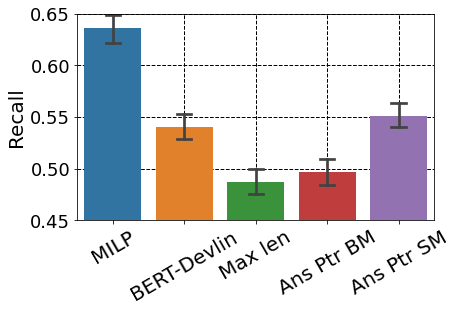

In [175]:
# statistic, pvalue = stats.ttest_ind(r2, r_baseline2)
plt.figure(figsize=(6.4, 3.8))

ax = sns.barplot(x="algo", y="recall", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} < 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Recall")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.45, 0.65)
plt.xticks(rotation=30)

plt.savefig('plots/recall_NewsQA.eps', bbox_inches = 'tight')
plt.show()


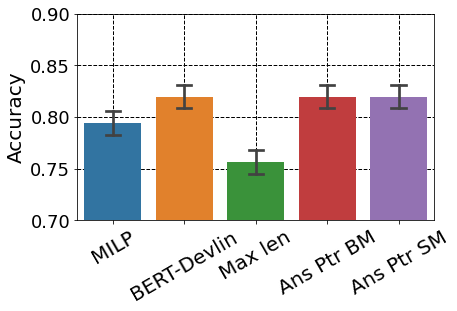

In [176]:
# statistic, pvalue = stats.ttest_ind(r2, r_baseline2)
plt.figure(figsize=(6.4, 3.8))

ax = sns.barplot(x="algo", y="clf_accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} < 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.9)
plt.xticks(rotation=30)

plt.savefig('plots/clf_accuracy_NewsQA.eps', bbox_inches = 'tight')
plt.show()


In [177]:
# This part is for the statistical tests
p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='BERT-Devlin']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='BERT-Devlin']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='BERT-Devlin']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='BERT-Devlin']['recall'])[1]
p_value_clf_accuracy = stats.ttest_ind(data[data['algo']=='MILP']['clf_accuracy'], data[data['algo']=='BERT-Devlin']['clf_accuracy'])[1]
print('\\textbf{MILP vs. BERT-Devlin} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f} \\\\' )

p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='Baseline 2']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='Baseline 2']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='Baseline 2']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='Baseline 2']['recall'])[1]
p_value_clf_accuracy = stats.ttest_ind(data[data['algo']=='MILP']['clf_accuracy'], data[data['algo']=='Baseline 2']['clf_accuracy'])[1]
print('\\textbf{MILP vs. Baseline 2} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f}  \\\\' )


p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='Ans Pt BM']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='Ans Pt BM']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='Ans Pt BM']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='Ans Pt BM']['recall'])[1]
p_value_clf_accuracy = stats.ttest_ind(data[data['algo']=='MILP']['clf_accuracy'], data[data['algo']=='Ans Pt BM']['clf_accuracy'])[1]
print('\\textbf{MILP vs. Ans Pt BM} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f}  \\\\' )


p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='Ans Pt SM']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='Baseline 2']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='Ans Pt SM']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='Ans Pt SM']['recall'])[1]
p_value_clf_accuracy = stats.ttest_ind(data[data['algo']=='MILP']['clf_accuracy'], data[data['algo']=='Ans Pt SM']['clf_accuracy'])[1]
print('\\textbf{MILP vs. Ans Pt SM} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f}  \\\\' )



\textbf{MILP vs. BERT-Devlin} & 0.0000 & 0.0001 & 0.0000 & 0.0000 \\
\textbf{MILP vs. Baseline 2} & nan & nan & nan & nan  \\
\textbf{MILP vs. Ans Pt BM} & nan & nan & nan & nan  \\
\textbf{MILP vs. Ans Pt SM} & nan & nan & nan & nan  \\
